In [1]:
%run utils

In [2]:
from torch import nn

class ConvBn(nn.Module):
    def __init__(self, *args, **kwargs):
        super(ConvBn, self).__init__()
        self.conv = nn.Conv2d(*args, **kwargs)
        self.bn = nn.BatchNorm2d(self.conv.out_channels)
        nn.init.kaiming_normal_(self.conv.weight)
        nn.init.zeros_(self.conv.bias)

    def forward(self, x):
        return self.bn(self.conv(x))

class ConvBnRelu(nn.Module):
    def __init__(self, *args, **kwargs):
        super(ConvBnRelu, self).__init__()
        self.conv = ConvBn(*args, **kwargs)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.relu(self.conv(x))

In [3]:
class ResUnit(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResUnit, self).__init__()
        self.conv1 = ConvBnRelu(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.conv2 = ConvBn(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.downsample = None
        if in_channels != out_channels or stride != 1:
            self.downsample = nn.Sequential(
                ConvBn(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        return nn.ReLU()(out)


unit = ResUnit(64, 128, stride=2)
print(unit)

ResUnit(
  (conv1): ConvBnRelu(
    (conv): ConvBn(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (relu): ReLU()
  )
  (conv2): ConvBn(
    (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (downsample): Sequential(
    (0): ConvBn(
      (conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)


In [4]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_units, stride=1):
        super(ResBlock, self).__init__()
        layers = []
        layers.append(ResUnit(in_channels, out_channels, stride=stride))
        for i in range(num_units - 1):
            layers.append(ResUnit(out_channels, out_channels, stride=1))
        self.blocks = nn.Sequential(*layers)

    def forward(self, x):
        return self.blocks(x)

block = ResBlock(64, 128, 2)
print(block)

ResBlock(
  (blocks): Sequential(
    (0): ResUnit(
      (conv1): ConvBnRelu(
        (conv): ConvBn(
          (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (relu): ReLU()
      )
      (conv2): ConvBn(
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (downsample): Sequential(
        (0): ConvBn(
          (conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
          (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResUnit(
      (conv1): ConvBnRelu(
        (conv): ConvBn(
          (conv): Conv2d(128, 128, kernel_size=(3, 3), str

In [5]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.conv1 = ConvBnRelu(3, 64, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.block1 = ResBlock(64, 64, 2)
        self.block2 = ResBlock(64, 128, 2, stride=2)
        self.block3 = ResBlock(128, 256, 2, stride=2)
        self.block4 = ResBlock(256, 512, 2, stride=2)
        self.pool2 = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.pool2(x)
        x = nn.Flatten()(x)
        x = self.fc(x)
        return x


In [6]:
from torchinfo import summary

net = ResNet()
summary(net, (1, 3, 32, 32))

Layer (type:depth-idx)                             Output Shape              Param #
ResNet                                             [1, 10]                   --
├─ConvBnRelu: 1-1                                  [1, 64, 32, 32]           --
│    └─ConvBn: 2-1                                 [1, 64, 32, 32]           --
│    │    └─Conv2d: 3-1                            [1, 64, 32, 32]           1,792
│    │    └─BatchNorm2d: 3-2                       [1, 64, 32, 32]           128
│    └─ReLU: 2-2                                   [1, 64, 32, 32]           --
├─MaxPool2d: 1-2                                   [1, 64, 16, 16]           --
├─ResBlock: 1-3                                    [1, 64, 16, 16]           --
│    └─Sequential: 2-3                             [1, 64, 16, 16]           --
│    │    └─ResUnit: 3-3                           [1, 64, 16, 16]           74,112
│    │    └─ResUnit: 3-4                           [1, 64, 16, 16]           74,112
├─ResBlock: 1-4        

In [7]:
from torchvision import datasets
from utils import train_val_split, PackDataset, trans_aug
from torchvision import transforms

full = datasets.CIFAR10(root="./data", train=True, download=True)
test = datasets.CIFAR10(root="./data", train=False, download=True)
train, valid = train_val_split(full, seed=666)

train_data = PackDataset(train, transform=trans_aug())
valid_data = PackDataset(valid, transform=transforms.ToTensor())
test_data = PackDataset(test, transform=transforms.ToTensor())

In [8]:
import json
from utils import control_callbacks
from sklearn.model_selection import ParameterGrid
import torch
from skorch import NeuralNetClassifier
from skorch.helper import predefined_split

In [ ]:
epochs = 15
param_grid = {
    'lr': [0.01, 0.005, 0.001, 0.0005, 0.0001],
    'decay': [1e-3, 5e-4, 2e-4, 1e-4, 5e-5]
}

results = {
    'best_params': None,
    'best_acc': 0.0,
    'all_results': []
}

calls = control_callbacks(epochs, check_dir='./data/alex-checkpoints', show_bar=False)
for params in ParameterGrid(param_grid):
    print(f"\nTraining with params: {params}")
    net = NeuralNetClassifier(
        ResNet,
        criterion=nn.CrossEntropyLoss,
        optimizer=torch.optim.Adam,
        lr=params['lr'],
        optimizer__weight_decay=params['decay'],
        batch_size=2048,
        max_epochs=epochs,
        train_split=predefined_split(valid_data),
        device='cuda' if torch.cuda.is_available() else 'cpu',
        callbacks=calls,
        classes=list(range(10)),
        iterator_train__num_workers=8,
        iterator_train__pin_memory=True,
    )
    net.fit(X=train_data, y=None)
    valid_acc = max(net.history[:, 'valid_acc'])
    current_result = {'params': params, 'valid_acc': valid_acc}
    results['all_results'].append(current_result)

    if valid_acc > results['best_acc']:
        results['best_acc'] = valid_acc
        results['best_params'] = params

    print(f"\nBest params: {results['best_params']}, best acc: {results['best_acc']}")

with open('./data/hyperparam_results.json', 'w') as f:
    json.dump(results, f, indent=2)

In [12]:
epochs = 45
calls = control_callbacks(epochs, check_dir='./data/alex-checkpoints', show_bar=False)
full_data = PackDataset(full, transform=trans_aug())
net = NeuralNetClassifier(
    ResNet,
    criterion=nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    lr=0.005,
    optimizer__weight_decay=0.001,
    batch_size=2048,
    max_epochs=epochs,
    train_split=predefined_split(test_data),
    device='cuda' if torch.cuda.is_available() else 'cpu',
    callbacks=calls,
    classes=list(range(10)),
    iterator_train__num_workers=8,
    iterator_train__pin_memory=True,
)
net.fit(full_data, y=None)

  epoch    train_acc    train_loss    valid_acc    valid_loss    cp      lr      dur
-------  -----------  ------------  -----------  ------------  ----  ------  -------
      1       0.2236        2.2540       0.2571        1.9933     +  0.0050  21.7871
      2       0.3658        1.7142       0.2927        1.9398     +  0.0050  22.0840
      3       0.4278        1.5710       0.3984        1.6621     +  0.0050  22.1729
      4       0.4811        1.4391       0.5179        1.3967     +  0.0049  22.4363
      5       0.5273        1.3232       0.4844        1.4273        0.0049  22.2170
      6       0.5707        1.2097       0.4592        1.4808        0.0048  22.3700
      7       0.6027        1.1332       0.4965        1.4232        0.0048  22.3060
      8       0.6297        1.0606       0.4717        1.5305        0.0047  22.5305
      9       0.6501        1.0057       0.5792        1.1726     +  0.0046  22.4106
     10       0.6818        0.9252       0.4159        1.9690    

,module,<class '__main__.ResNet'>
,criterion,<class 'torch...sEntropyLoss'>
,train_split,functools.par...7f482d00e3b0>)
,classes,"[0, 1, ...]"
,optimizer,<class 'torch...im.adam.Adam'>
,lr,0.005
,max_epochs,45
,batch_size,2048
,iterator_train,<class 'torch...r.DataLoader'>
,iterator_valid,<class 'torch...r.DataLoader'>
,dataset,<class 'skorc...aset.Dataset'>


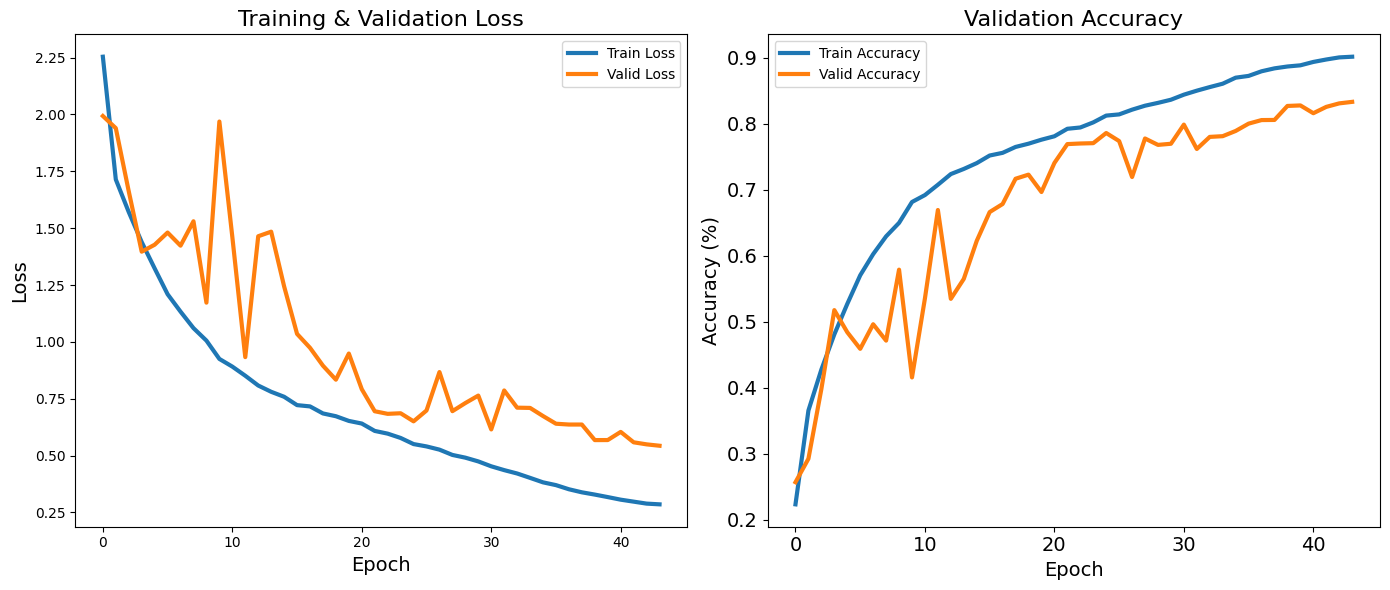

In [13]:
from utils import plot_history, check_result

plot_history(net)

Test Accuracy: 0.8335
Confusion Matrix:
 [[884  15  29  10   5   0  12   6  18  21]
 [  1 969   1   0   0   0   1   0   1  27]
 [ 34   4 815  15  22  11  78  11   0  10]
 [ 17  13  48 580  40  70 173  25  10  24]
 [  9   5  40  11 791   2 121  21   0   0]
 [ 10   8  39  75  39 633 128  48   4  16]
 [  4   1   9   7   3   1 970   1   0   4]
 [ 17   3  12   8  22   7  31 890   0  10]
 [ 46  30   1   5   3   0  11   0 885  19]
 [ 12  54   0   1   0   0   8   2   5 918]]


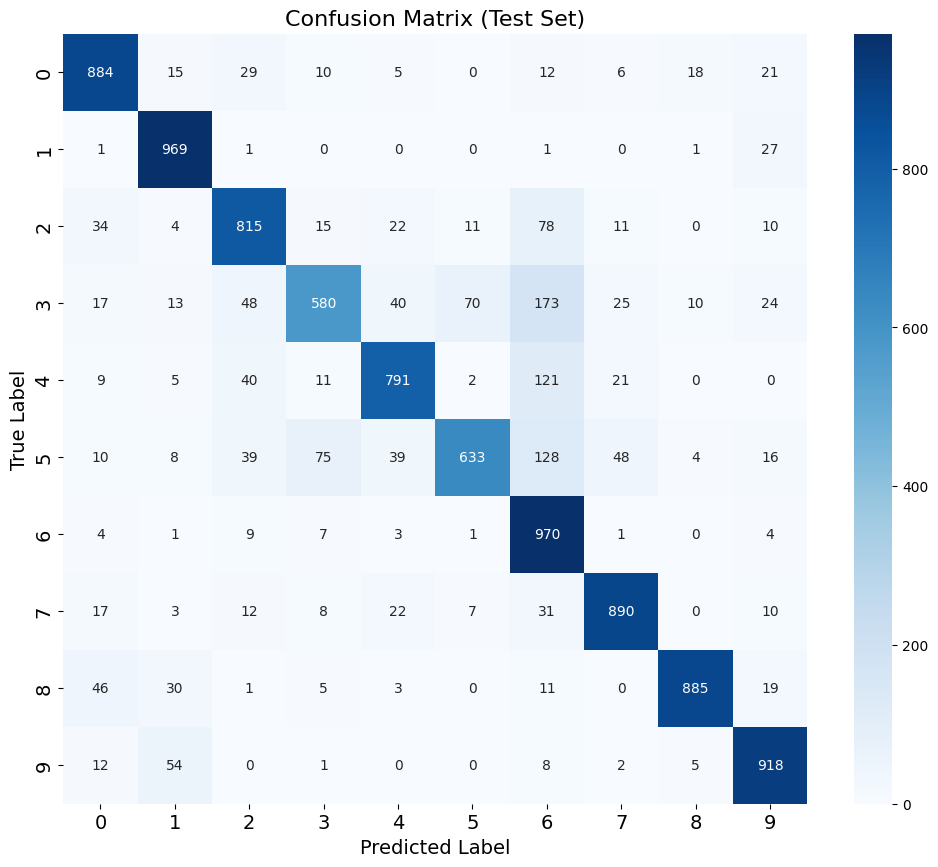

error number: 1665


[{'features': tensor([[[0.5333, 0.5569, 0.5843,  ..., 0.6627, 0.5804, 0.3176],
           [0.5529, 0.5294, 0.5686,  ..., 0.6784, 0.5843, 0.3255],
           [0.5608, 0.4941, 0.5294,  ..., 0.6863, 0.6039, 0.3333],
           ...,
           [0.5765, 0.5765, 0.5843,  ..., 0.5647, 0.5686, 0.5294],
           [0.5294, 0.5451, 0.5569,  ..., 0.5490, 0.5451, 0.5412],
           [0.4588, 0.4745, 0.5059,  ..., 0.5176, 0.5176, 0.5255]],
  
          [[0.5255, 0.5529, 0.5882,  ..., 0.6667, 0.5922, 0.3412],
           [0.5490, 0.5373, 0.5725,  ..., 0.6863, 0.6039, 0.3529],
           [0.5569, 0.5059, 0.5412,  ..., 0.6980, 0.6235, 0.3608],
           ...,
           [0.6745, 0.6588, 0.6431,  ..., 0.7608, 0.7686, 0.7412],
           [0.6902, 0.6902, 0.7098,  ..., 0.7725, 0.7647, 0.7569],
           [0.6824, 0.6941, 0.7137,  ..., 0.7412, 0.7294, 0.7255]],
  
          [[0.4627, 0.4941, 0.5176,  ..., 0.5922, 0.4863, 0.2549],
           [0.4941, 0.4706, 0.4980,  ..., 0.5961, 0.4784, 0.2549],
          

In [14]:
check_result(net, test_data)

In [9]:
class ResNet18Backbone(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = ConvBnRelu(3, 64, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.block1 = ResBlock(64, 64, 2)
        self.block2 = ResBlock(64, 128, 2, stride=2)
        self.block3 = ResBlock(128, 256, 2, stride=2)
        self.block4 = ResBlock(256, 512, 2, stride=2)
        self.pool2 = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.pool2(x)
        return nn.Flatten()(x)

In [12]:
backbone = ResNet18Backbone()
summary(net, (1, 3, 32, 32))

Layer (type:depth-idx)                             Output Shape              Param #
ResNet                                             [1, 10]                   --
├─ConvBnRelu: 1-1                                  [1, 64, 32, 32]           --
│    └─ConvBn: 2-1                                 [1, 64, 32, 32]           --
│    │    └─Conv2d: 3-1                            [1, 64, 32, 32]           1,792
│    │    └─BatchNorm2d: 3-2                       [1, 64, 32, 32]           128
│    └─ReLU: 2-2                                   [1, 64, 32, 32]           --
├─MaxPool2d: 1-2                                   [1, 64, 16, 16]           --
├─ResBlock: 1-3                                    [1, 64, 16, 16]           --
│    └─Sequential: 2-3                             [1, 64, 16, 16]           --
│    │    └─ResUnit: 3-3                           [1, 64, 16, 16]           74,112
│    │    └─ResUnit: 3-4                           [1, 64, 16, 16]           74,112
├─ResBlock: 1-4        

In [14]:
class ResNet18Classifier(nn.Module):
    def __init__(self, backbone, num_classes=100):
        super().__init__()
        self.backbone = backbone
        self.fc = nn.Linear(512, num_classes)
        self.freeze_backbone(True)

    def forward(self, x):
        features = self.backbone(x)
        return self.fc(features)

    def freeze_backbone(self, freeze=True):
        for param in self.backbone.parameters():
            param.requires_grad = not freeze

    def get_backbone_state_dict(self):
        return self.backbone.state_dict()

    def load_backbone_state_dict(self, state_dict):
        self.backbone.load_state_dict(state_dict)

In [16]:
resnet18 = ResNet18Classifier(backbone)
summary(resnet18, (1, 3, 32, 32))

Layer (type:depth-idx)                                  Output Shape              Param #
ResNet18Classifier                                      [1, 100]                  --
├─ResNet18Backbone: 1-1                                 [1, 512]                  --
│    └─ConvBnRelu: 2-1                                  [1, 64, 32, 32]           --
│    │    └─ConvBn: 3-1                                 [1, 64, 32, 32]           (1,920)
│    │    └─ReLU: 3-2                                   [1, 64, 32, 32]           --
│    └─MaxPool2d: 2-2                                   [1, 64, 16, 16]           --
│    └─ResBlock: 2-3                                    [1, 64, 16, 16]           --
│    │    └─Sequential: 3-3                             [1, 64, 16, 16]           (148,224)
│    └─ResBlock: 2-4                                    [1, 128, 8, 8]            --
│    │    └─Sequential: 3-4                             [1, 128, 8, 8]            (526,464)
│    └─ResBlock: 2-5                     